In [1]:
!pip install tensorflow --upgrade

     |████████████████████████████████| 86.3MB 137kB/s 
     |████████████████████████████████| 450kB 50.8MB/s 
     |████████████████████████████████| 3.8MB 35.5MB/s 
     |████████████████████████████████| 81kB 11.3MB/s 
ERROR: tensorboard 2.0.1 has requirement grpcio>=1.24.3, but you'll have grpcio 1.15.0 which is incompatible.
ERROR: google-colab 1.0.0 has requirement google-auth~=1.4.0, but you'll have google-auth 1.6.3 which is incompatible.
  Found existing installation: tensorflow-estimator 1.15.1
    Uninstalling tensorflow-estimator-1.15.1:
      Successfully uninstalled tensorflow-estimator-1.15.1
  Found existing installation: google-auth 1.4.2
    Uninstalling google-auth-1.4.2:
      Successfully uninstalled google-auth-1.4.2
  Found existing installation: tensorboard 1.15.0
    Uninstalling tensorboard-1.15.0:
      Successfully uninstalled tensorboard-1.15.0
  Found existing installation: tensorflow 1.15.0
    Uninstalling tensorflow-1.15.0:
      Successfully uninstall

In [2]:
!git clone https://github.com/Bourn23/NTIRE.git

Cloning into 'super-resolution'...
remote: Enumerating objects: 8, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 375 (delta 1), reused 4 (delta 1), pack-reused 367
Receiving objects: 100% (375/375), 49.37 MiB | 37.01 MiB/s, done.
Resolving deltas: 100% (188/188), done.


# EDSR

In [0]:
import os
import matplotlib.pyplot as plt

os.chdir('/content/super-resolution')

from data import DIV2K
from model.edsr import bdsr
from train import BdsrTrainer

%matplotlib inline

In [0]:
# Number of residual blocks
depth = 4

# Super-resolution factor
scale = 4

# Downgrade operator
downgrade = 'bicubic'

In [0]:
# Location of model weights (needed for demo)
weights_dir = f'weights/edsr-{depth}-x{scale}'
weights_file = os.path.join(weights_dir, 'weights.h5')

os.makedirs(weights_dir, exist_ok=True)

## Datasets

You don't need to download the DIV2K dataset as the required parts are automatically downloaded by the `DIV2K` class. By default, DIV2K images are stored in folder `.div2k` in the project's root directory.

In [0]:
div2k_train = DIV2K(scale=scale, subset='train', downgrade=downgrade)
div2k_valid = DIV2K(scale=scale, subset='valid', downgrade=downgrade)

In [5]:
train_ds = div2k_train.dataset(batch_size=16, random_transform=True)
valid_ds = div2k_valid.dataset(batch_size=1, random_transform=False, repeat_count=1)

925392896/925390592 [==============================] - 52s 0us/step
Caching decoded images in .div2k/caches/DIV2K_train_LR_bicubic_X2.cache ...
Cached decoded images in .div2k/caches/DIV2K_train_LR_bicubic_X2.cache.
3530604544/3530603713 [==============================] - 170s 0us/step
Caching decoded images in .div2k/caches/DIV2K_train_HR.cache ...
Cached decoded images in .div2k/caches/DIV2K_train_HR.cache.
117768192/117763600 [==============================] - 6s 0us/step
Caching decoded images in .div2k/caches/DIV2K_valid_LR_bicubic_X2.cache ...
Cached decoded images in .div2k/caches/DIV2K_valid_LR_bicubic_X2.cache.
448995328/448993893 [==============================] - 22s 0us/step
Caching decoded images in .div2k/caches/DIV2K_valid_HR.cache ...
Cached decoded images in .div2k/caches/DIV2K_valid_HR.cache.


## Training

### Pre-trained models

If you want to skip training and directly run the demo below, download [weights-edsr-16-x4.tar.gz](https://drive.google.com/open?id=1xjyW_0dDS4jSTxKVZwtlkyfS4Oso-GUF) and extract the archive in the project's root directory. This will create a `weights/edsr-16-x4` directory containing the weights of the pre-trained model.

In [0]:
# TEST


import tensorflow as tf
from tensorflow.python.keras.layers import Add, Conv2D, Input, Lambda
from tensorflow.python.keras.models import Model

from model.common import normalize, denormalize, pixel_shuffle


def edsr(scale, num_filters=64, num_res_blocks=4, res_block_scaling= None):
    x_in = Input(shape=(None, None, 3))
    x = Lambda(normalize)(x_in)

    x = b = Conv2D(num_filters, 3, padding='same')(x)
    for i in range(num_res_blocks):
        b = res_block(b, num_filters, res_block_scaling)
    x = Conv2D(num_filters, 3, padding='same')(b)
    x = Add()([x, b])

    x = upsample(x, scale, num_filters)
    x = Conv2D(3, 3, padding='same')(x)

    x = Lambda(denormalize)(x)
    return Model(x_in, x, name="edsr")


def res_block(x_in, filters, scale = None):
  x1 = Conv2D(filters, [1, 1], padding = 'same', activation = 'relu')(x_in)
  x2_1 = Conv2D(filters, [3, 1], padding = 'same')(x_in)
  x2_2 = Conv2D(x2_1.shape[3], [1, 3], padding = 'same', activation = 'relu')(x2_1)
  y = Add()([x1, x2_2])
  y = Conv2D(y.shape[3], [1, 1])(y)
  if scale:
    y = Lambda(pixel_shuffle(scale=scale))(y)
    return Conv2D(16, [49, 49], padding = 'valid', activation = 'relu')(y)
  return y


def upsample(x, scale, num_filters):
    def upsample_1(x, factor, **kwargs):
        x = Conv2D(num_filters * (factor ** 2), 3, padding='same', **kwargs)(x)
        return Lambda(pixel_shuffle(scale=factor))(x)

    if scale == 2:
        x = upsample_1(x, 2, name='conv2d_1_scale_2')
    elif scale == 3:
        x = upsample_1(x, 3, name='conv2d_1_scale_3')
    elif scale == 4:
        x = upsample_1(x, 2, name='conv2d_1_scale_2')
        x = upsample_1(x, 2, name='conv2d_2_scale_2')

    return x

In [25]:
import time
import tensorflow as tf

from model import evaluate
from model import srgan

from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.losses import MeanAbsoluteError
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import Mean
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import PiecewiseConstantDecay


class Trainer:
    def __init__(self,
                 model,
                 loss,
                 learning_rate,
                 checkpoint_dir='./ckpt/edsr'):

        self.now = None
        self.loss = loss
        self.checkpoint = tf.train.Checkpoint(step=tf.Variable(0),
                                              psnr=tf.Variable(-1.0),
                                              optimizer=Adam(learning_rate),
                                              model=model)
        self.checkpoint_manager = tf.train.CheckpointManager(checkpoint=self.checkpoint,
                                                             directory=checkpoint_dir,
                                                             max_to_keep=3)

        self.restore()

    @property
    def model(self):
        return self.checkpoint.model

    def train(self, train_dataset, valid_dataset, steps, evaluate_every=1000, save_best_only=False):
        loss_mean = Mean()

        ckpt_mgr = self.checkpoint_manager
        ckpt = self.checkpoint

        self.now = time.perf_counter()

        for lr, hr in train_dataset.take(steps - ckpt.step.numpy()):
            ckpt.step.assign_add(1)
            step = ckpt.step.numpy()

            loss = self.train_step(lr, hr)
            loss_mean(loss)

            if step % evaluate_every == 0:
                loss_value = loss_mean.result()
                loss_mean.reset_states()

                # Compute PSNR on validation dataset
                psnr_value = self.evaluate(valid_dataset)

                duration = time.perf_counter() - self.now
                print(f'{step}/{steps}: loss = {loss_value.numpy():.3f}, PSNR = {psnr_value.numpy():3f} ({duration:.2f}s)')

                if save_best_only and psnr_value <= ckpt.psnr:
                    self.now = time.perf_counter()
                    # skip saving checkpoint, no PSNR improvement
                    continue

                ckpt.psnr = psnr_value
                ckpt_mgr.save()

                self.now = time.perf_counter()

    @tf.function
    def train_step(self, lr, hr):
        with tf.GradientTape() as tape:
            lr = tf.cast(lr, tf.float32)
            hr = tf.cast(hr, tf.float32)

            sr = self.checkpoint.model(lr, training=True)
            loss_value = self.loss(hr, sr)

        gradients = tape.gradient(loss_value, self.checkpoint.model.trainable_variables)
        self.checkpoint.optimizer.apply_gradients(zip(gradients, self.checkpoint.model.trainable_variables))

        return loss_value

    def evaluate(self, dataset):
        return evaluate(self.checkpoint.model, dataset)

    def restore(self):
        if self.checkpoint_manager.latest_checkpoint:
            self.checkpoint.restore(self.checkpoint_manager.latest_checkpoint)
            print(f'Model restored from checkpoint at step {self.checkpoint.step.numpy()}.')


class EdsrTrainer(Trainer):
    def __init__(self,
                 model,
                 checkpoint_dir,
                 learning_rate=ExponentialDecay(boundaries=[1500], values=[2e-4, 3e-3])): #3e-5
        super().__init__(model, loss=MeanSquaredError(), learning_rate=learning_rate, checkpoint_dir=checkpoint_dir)

    def train(self, train_dataset, valid_dataset, steps=300000, evaluate_every=1000, save_best_only=True):
        super().train(train_dataset, valid_dataset, steps, evaluate_every, save_best_only)

TypeError: ignored

## Edits:
* 2200... PSNR: 31.77
  * Change to MeanSquaredError

In [17]:
trainer = EdsrTrainer(model=edsr(scale=scale, num_res_blocks=depth), 
                      checkpoint_dir=f'.ckpt/edsr-{depth}-x{scale}')

Model restored from checkpoint at step 2200.


In [15]:
# Train EDSR model for 300,000 steps and evaluate model
# every 1000 steps on the first 10 images of the DIV2K
# validation set. Save a checkpoint only if evaluation
# PSNR has improved.
trainer.train(train_ds,
              valid_ds.take(10),
              steps=10000, 
              evaluate_every=100, 
              save_best_only=True)

600/10000: loss = 10.539, PSNR = 27.918308 (390.32s)
700/10000: loss = 8.574, PSNR = 28.475338 (387.90s)
800/10000: loss = 8.064, PSNR = 29.169830 (388.10s)
900/10000: loss = 6.913, PSNR = 29.984283 (388.43s)
1000/10000: loss = 6.889, PSNR = 30.342640 (384.67s)
1100/10000: loss = 7.148, PSNR = 29.474255 (377.63s)
1200/10000: loss = 6.515, PSNR = 30.123524 (391.37s)
1300/10000: loss = 6.585, PSNR = 30.645203 (381.08s)
1400/10000: loss = 6.274, PSNR = 30.259562 (381.78s)
1500/10000: loss = 6.348, PSNR = 30.651941 (387.41s)
1600/10000: loss = 5.447, PSNR = 31.597397 (382.20s)
1700/10000: loss = 5.430, PSNR = 31.598682 (379.16s)
1800/10000: loss = 5.363, PSNR = 31.625738 (386.40s)
1900/10000: loss = 5.369, PSNR = 31.675156 (385.34s)
2000/10000: loss = 5.320, PSNR = 31.697208 (382.91s)
2100/10000: loss = 5.227, PSNR = 31.759058 (379.28s)
2200/10000: loss = 5.227, PSNR = 31.774456 (381.10s)
2300/10000: loss = 5.104, PSNR = 31.715490 (382.28s)


KeyboardInterrupt: ignored

In [0]:
# Restore from checkpoint with highest PSNR
trainer.restore()

In [24]:
# Evaluate model on full validation set
psnrv = trainer.evaluate(valid_ds)
print(f'PSNR = {psnrv.numpy():3f}')

PSNR = 31.043285


In [0]:
# Save weights to separate location (needed for demo)
trainer.model.save_weights(weights_file)

## Demo

In [0]:
model = edsr(scale=scale, num_res_blocks=depth)
model.load_weights(weights_file)

In [0]:
from model import resolve_single
from utils import load_image, plot_sample

def resolve_and_plot(lr_image_path):
    lr = load_image(lr_image_path)
    sr = resolve_single(model, lr)
    plot_sample(lr, sr)

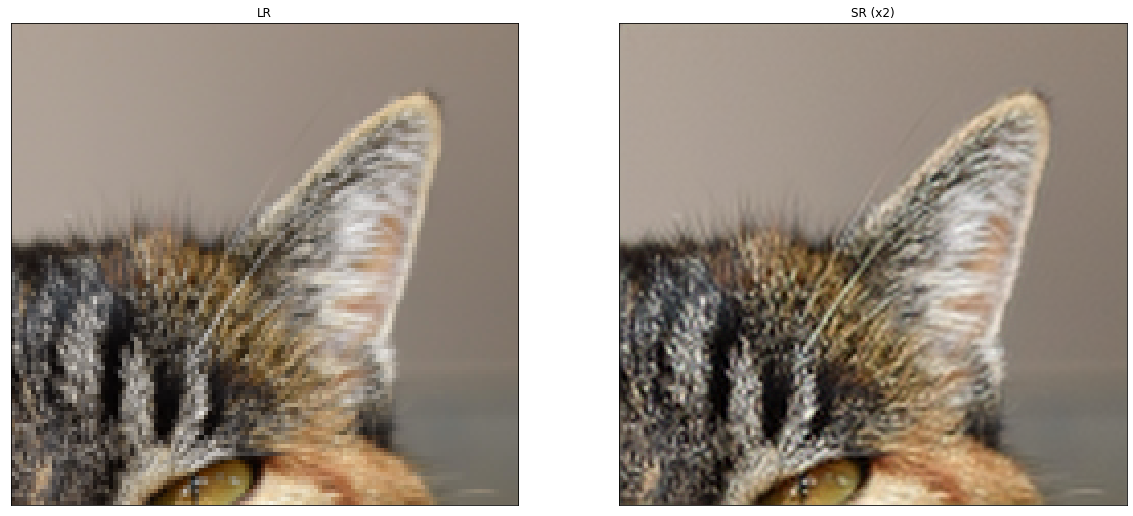

In [21]:
resolve_and_plot('demo/0869x4-crop.png')

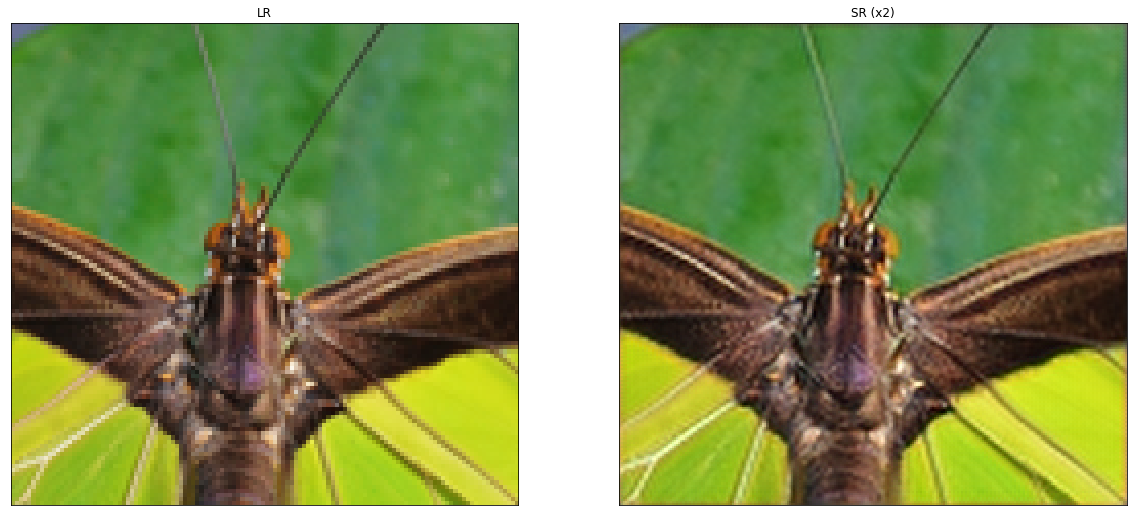

In [22]:
resolve_and_plot('demo/0829x4-crop.png')

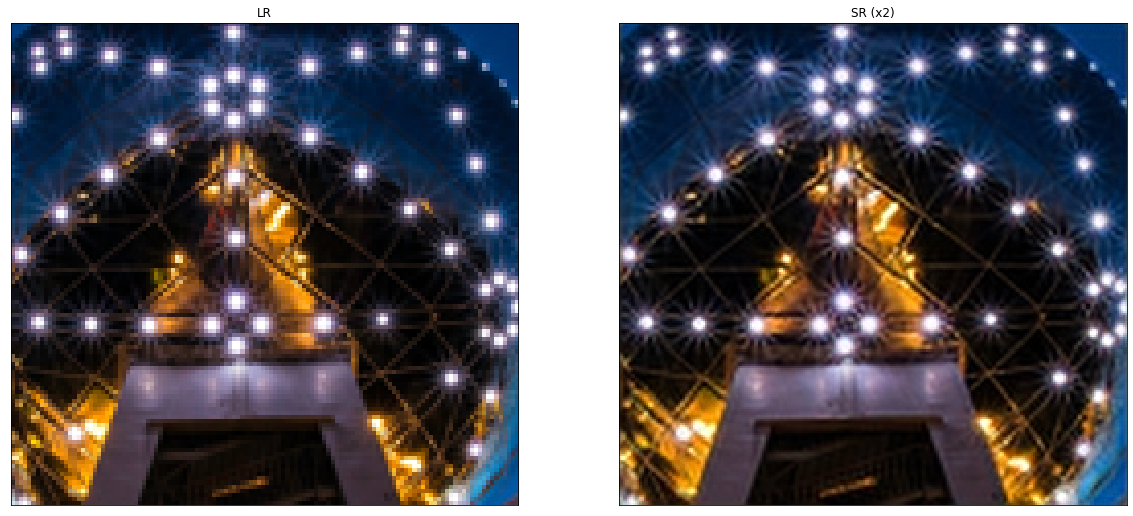

In [23]:
resolve_and_plot('demo/0851x4-crop.png')